# Model performance comparison

In [5]:
import sys
import os
sys.path.append(os.path.abspath("/mnt/qmtang/EvoFill"))  # 把上级目录加入路径
from src.eval_metrics import load_gt_matrix, analyze_by_maf_bins, plot_maf_results, plot_stacked_bar_chart_with_error_bars, plot_violin_plots

In [8]:
# File paths 暂设vcf文件与.ipynb文件在同一目录下
test_vcf = "/mnt/qmtang/EvoFill/data/sim_0910/PopB.missing50.vcf.gz"
pred_vcf = "/home/qmtang/GitHub/STICI/sim_0910/out/ligated_results.BGZF.vcf.gz"
true_vcf = "/mnt/qmtang/EvoFill/data/sim_0910/PopB.vcf.gz"

Loading VCF files...

=== MISSING GENOTYPES STATISTICS ===
Total genotype positions in test file: 50649000
Total missing genotypes (need imputation): 25324190
Missing rate: 0.5000 (50.00%)
Missing genotypes that can be evaluated: 25324190
Evaluation coverage: 1.0000 (100.00%)
=== MAF-based Analysis ===
Total samples: 1000
Total variants analyzed: 50649

Sum of N_Imputations across all MAF bins: 25323716
Should equal evaluable missing genotypes: 25324190
? N_Imputations verification FAILED
Difference: 474

MAF-BASED IMPUTATION PERFORMANCE ANALYSIS
MAF Bin      N_Variants   N_Imputations   Accuracy   IQS        INFO       MaCH-Rsq  
--------------------------------------------------------------------------------
0.00-0.05    43061        21530436        0.8753     0.2416     -0.3933    0.0754    
0.05-0.10    1916         958656          0.7926     0.0733     0.7527     0.0369    
0.10-0.20    2166         1083638         0.6373     0.0730     0.6723     0.0389    
0.20-0.30    1324     

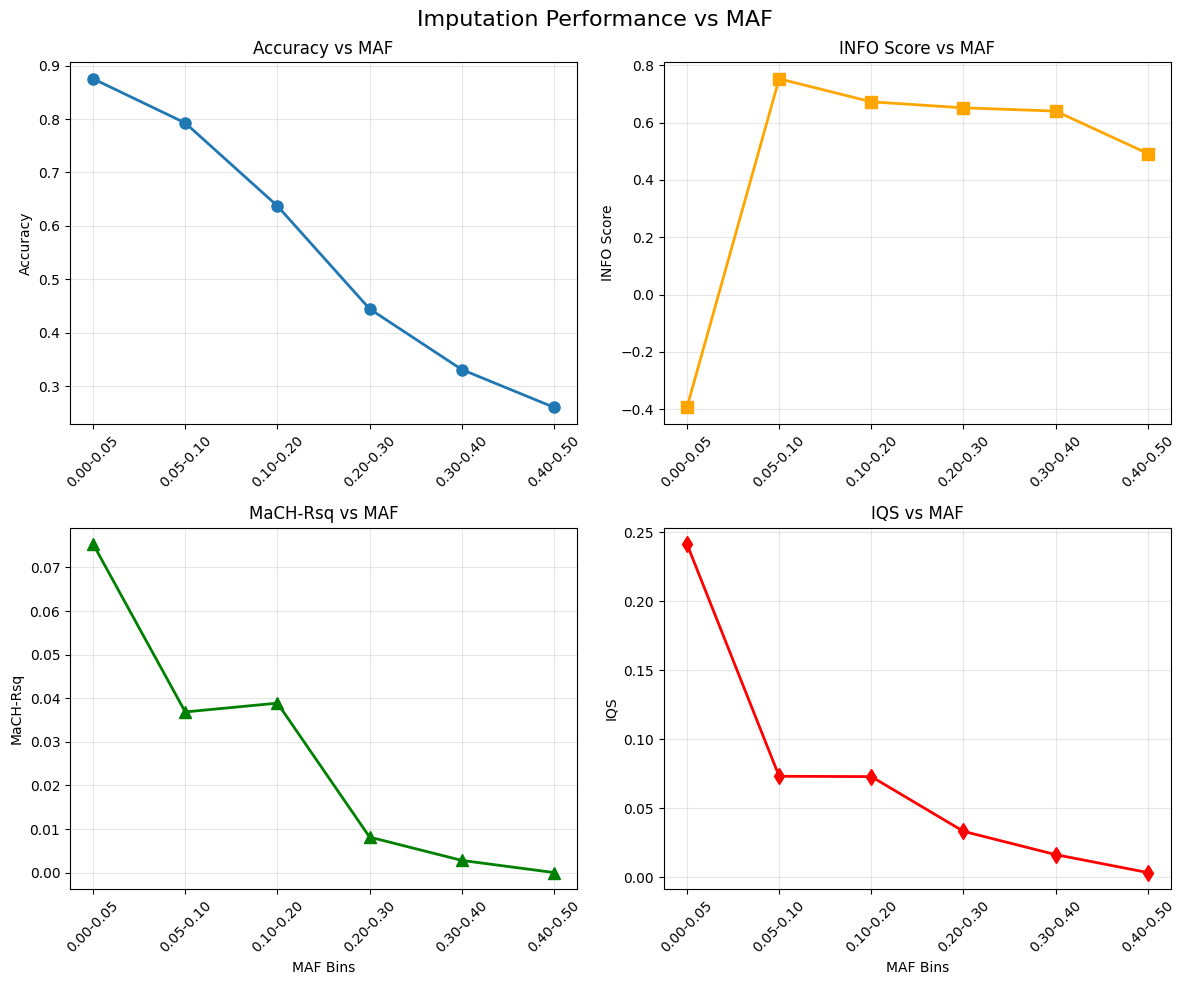

Original line plots saved as 'maf_analysis_results.png'


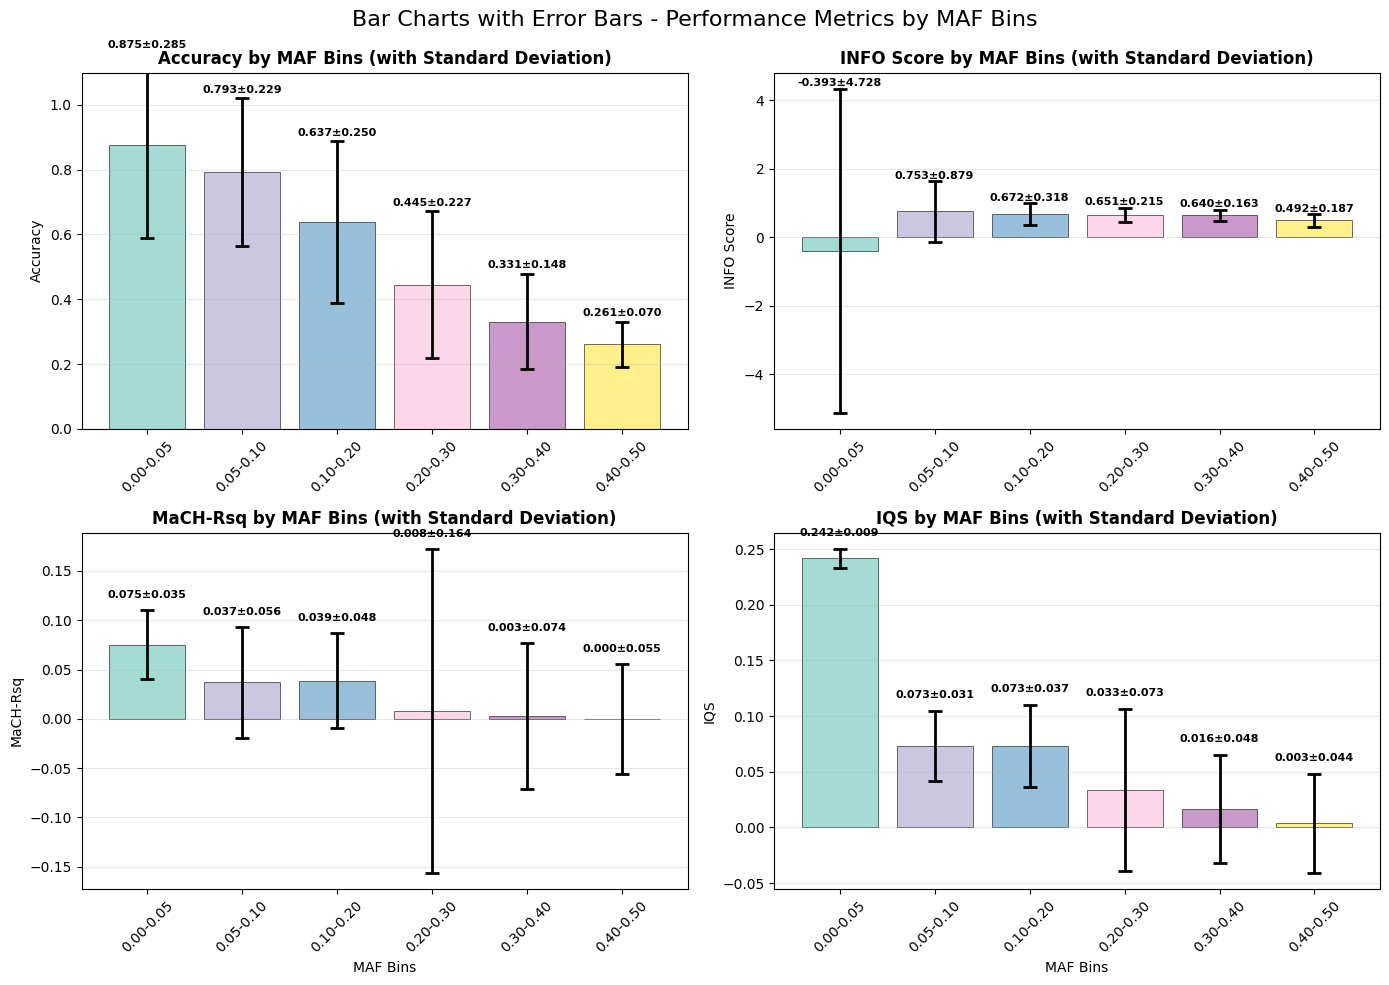

Stacked bar chart saved as 'maf_stacked_bar_chart.png'


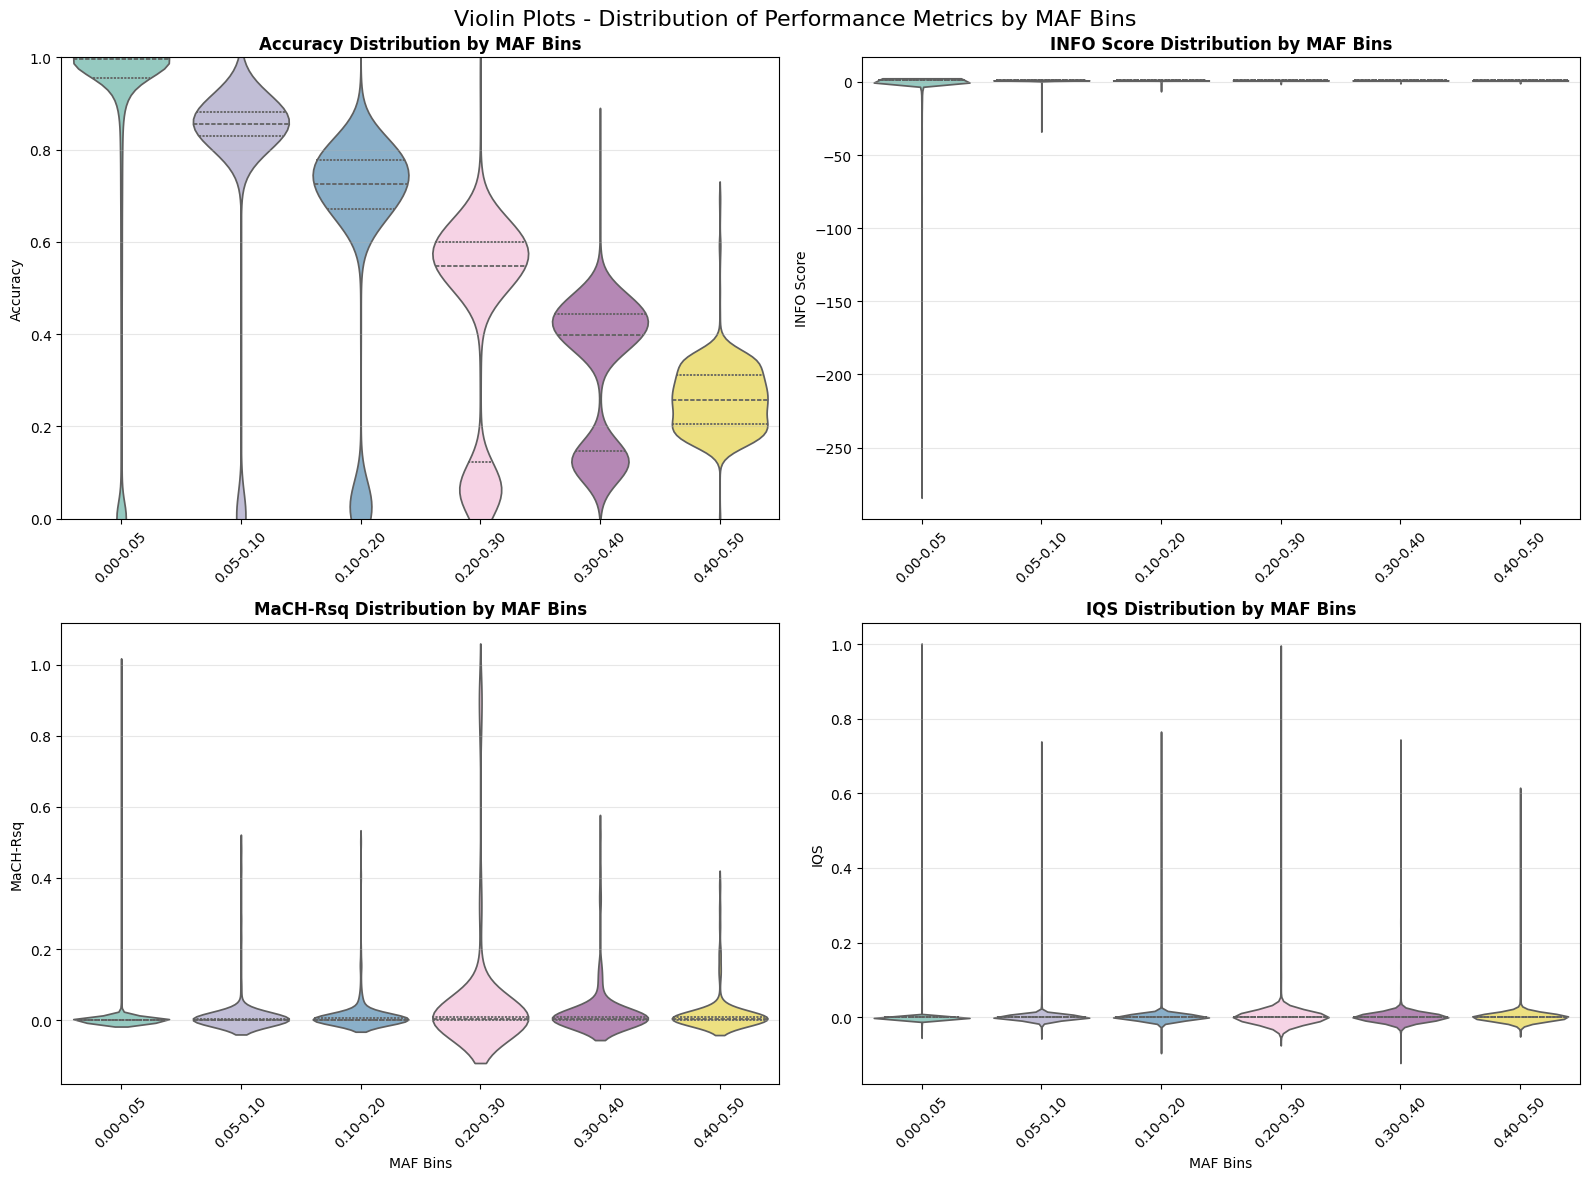

Violin plots saved as 'maf_violin_plots.png'


In [10]:
# Load genotype matrices
print("Loading VCF files...")
test_gt = load_gt_matrix(test_vcf)
pred_gt = load_gt_matrix(pred_vcf)
true_gt = load_gt_matrix(true_vcf)

# Count total missing genotypes in test file
print("\n=== MISSING GENOTYPES STATISTICS ===")
total_missing = 0
total_positions = 0

for variant_key in test_gt:
    for sample in test_gt[variant_key]:
        total_positions += 1
        if test_gt[variant_key][sample] in [".|.", "./."]:
            total_missing += 1

print(f"Total genotype positions in test file: {total_positions}")
print(f"Total missing genotypes (need imputation): {total_missing}")
print(f"Missing rate: {total_missing / total_positions:.4f} ({total_missing / total_positions * 100:.2f}%)")

# Count how many can be evaluated (have both pred and true)
evaluable_missing = 0
for variant_key in test_gt:
    if variant_key not in true_gt or variant_key not in pred_gt:
        continue
    for sample in test_gt[variant_key]:
        if test_gt[variant_key][sample] in [".|.", "./."]:
            if sample in pred_gt[variant_key] and sample in true_gt[variant_key]:
                evaluable_missing += 1

print(f"Missing genotypes that can be evaluated: {evaluable_missing}")
print(
    f"Evaluation coverage: {evaluable_missing / total_missing:.4f} ({evaluable_missing / total_missing * 100:.2f}%)")

# Perform MAF-based analysis
bin_results, bin_detailed_results = analyze_by_maf_bins(test_gt, pred_gt, true_gt)

# Verify N_Imputations sum
total_n_imputations = sum(results['n_imputations'] for results in bin_results.values())
print(f"\nSum of N_Imputations across all MAF bins: {total_n_imputations}")
print(f"Should equal evaluable missing genotypes: {evaluable_missing}")
if total_n_imputations == evaluable_missing:
    print("? N_Imputations verification PASSED")
else:
    print("? N_Imputations verification FAILED")
    print(f"Difference: {evaluable_missing - total_n_imputations}")

# Print results
print("\n" + "=" * 80)
print("MAF-BASED IMPUTATION PERFORMANCE ANALYSIS")
print("=" * 80)
print(
    f"{'MAF Bin':<12} {'N_Variants':<12} {'N_Imputations':<15} {'Accuracy':<10} {'IQS':<10} {'INFO':<10} {'MaCH-Rsq':<10}")
print("-" * 80)

for bin_name, results in bin_results.items():
    print(f"{bin_name:<12} {results['n_variants']:<12} {results['n_imputations']:<15} "
            f"{results['accuracy']:<10.4f} {results['iqs']:<10.4f} "
            f"{results['info_score']:<10.4f} {results['mach_rsq']:<10.4f}")

# Generate all visualizations
print("\nGenerating visualizations...")

# Original line plot
plot_maf_results(bin_results)
print("Original line plots saved as 'maf_analysis_results.png'")

# New stacked bar chart
plot_stacked_bar_chart_with_error_bars(bin_results, bin_detailed_results)
print("Stacked bar chart saved as 'maf_stacked_bar_chart.png'")

# New violin plots
plot_violin_plots(bin_detailed_results)
print("Violin plots saved as 'maf_violin_plots.png'")